
## <center>**Federal Election Voting Trends by Division between 2004 and 2022**</center>


#### **Introduction**

-----------------

The aim of this study is to investigate general voter turn out and whether there are any trends in the types of votes counted over the last several federal election. For example, is there any trend in the number of people preferring to vote early rather than on election day? Are there differences in voting method preferences between divisions? If so, is there a characteristic shared among the divisions who preference a particular voting method? Are roughly the same amount of people voting each election or does it change significantly? 

This study seeks to answer these questions.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set up read_csv to read in all election files
vote2004 = pd.read_csv("HouseVotesCountedByDivision2004.csv", header = 1)
vote2007 = pd.read_csv("HouseVotesCountedByDivision2007.csv", header = 1)
vote2010 = pd.read_csv("HouseVotesCountedByDivision2010.csv", header = 1)
vote2013 = pd.read_csv("HouseVotesCountedByDivision2013.csv", header = 1)
vote2016 = pd.read_csv("HouseVotesCountedByDivision2016.csv", header = 1)
vote2019 = pd.read_csv("HouseVotesCountedByDivision2019.csv", header = 1)
vote2022 = pd.read_csv("HouseVotesCountedByDivision2022.csv", header = 1)

Data for this study can be found at <https://results.aec.gov.au/> in the Australian Electoral Commision Tally Room Archive. This study on looks at data for the House of Representatives, specifically the "votes by division". This data includes the ID and name for each division (a.k.a electorate), the state the division is in, total number of enrolled in each division, how many votes were cast for each vote type, the total votes, and the total percentage of voter turn out. 

There are five different vote types measured, they are:
   
* **Ordinary Votes**: A vote recorded at a polling place within the division for which the voter is enrolled.
* **Absent Votes**: A declaration vote cast at a polling place outside of a voter's electoral division, but still within their state or territory.
* **Provisional Votes**: A vote cast when a voter's name cannot be found on the certified list, the voter's name is already marked off the certified
  list as having voted, or the voter’s address is suppressed.
* **PrePoll Votes**: A vote cast at a pre-poll voting centre before polling day.
* **Postal Votes**: A vote issued to, and usually returned by, the voter by post.

Here is a brief example of the data.

In [3]:
vote2004.head(10)

,DivisionID,DivisionNm,StateAb,Enrolment,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,TotalPercentage
0,179,Adelaide,SA,95060,73562,6264,499,4024,4647,88996,93.62
1,197,Aston,VIC,88549,71585,4504,304,3401,5221,85015,96.01
2,198,Ballarat,VIC,90409,70503,3934,728,6484,5104,86753,95.96
3,103,Banks,NSW,83292,66734,4578,421,3401,4066,79200,95.09
4,180,Barker,SA,100934,82517,4935,464,4725,3735,96376,95.48
5,104,Barton,NSW,84595,67687,4232,719,3558,3696,79892,94.44
6,192,Bass,TAS,67941,54923,2685,700,3283,3382,64973,95.63
7,199,Batman,VIC,85747,66937,4905,499,3192,4697,80230,93.57
8,200,Bendigo,VIC,94295,75642,4135,702,5409,4821,90709,96.20
9,105,Bennelong,NSW,86220,67991,4710,403,3947,4525,81576,94.61


Some work must be done to arrange the data into a suitable format to gain the desired insights. Merging the data into one table is advantageous to comparing different elections but requires an extra data point for each entry that marks which election the entry comes from. This merged data frame allows comparison of individual division but creating a table that is aggregated by year also allows for broader comparisons of voting trends in the entire nation across elections.

Out of these two data tables all comparisons relevant to this study can be made.

In [4]:
# add a year column so the data can still be identified after merging dataframes
vote2004["year"] = 2004
vote2007["year"] = 2007
vote2010["year"] = 2010
vote2013["year"] = 2013
vote2016["year"] = 2016
vote2019["year"] = 2019
vote2022["year"] = 2022

In [5]:
# merge the dataframes to compare data
vote_merged = pd.concat([vote2004,vote2007,vote2010,vote2013,vote2016,vote2019,vote2022], axis = 0).reset_index(drop = True)

In [6]:
# create dataframe grouped by year with percentage turn out recalculated
vote_merge_year = vote_merged.drop(["TotalPercentage", "DivisionID", "DivisionNm", "StateAb"], axis = 1).groupby("year").sum()
vote_merge_year["TotalPercentage"] = round(vote_merge_year["TotalVotes"]/vote_merge_year["Enrolment"] *100, 2)

The tables record the vote data as a sum of all the votes of a given type but each division and each election has a varying number of people elligible to vote. In order to make reasonable comparisons between elections and divisions it is necessary to compare the percentages of votes out of the total possible votes in each case. This normalizes the data and keeps comparisons fair.

In [7]:
# create function to calculate percentages of each vote type for both combined dataframes
def percent_calc(df, var_list):
    '''
    Changes the values in the columns of the vote types given in var_list given to percentages of total votes 
    df = Dataframe for the variable that need to be converted to percentage
    var_list = list of variables to convert to percent
    '''
    new_df = df.copy()
    for var in var_list:
        new_df[var] = round(new_df[var]/new_df["TotalVotes"]*100,2)
    return new_df

In [8]:
# run function
vote_types = ["OrdinaryVotes", "AbsentVotes", "ProvisionalVotes", "PrePollVotes", "PostalVotes"]
vote_merged_percent = percent_calc(vote_merged, vote_types)
vote_merge_year_percent = percent_calc(vote_merge_year, vote_types)

#### **Voter Turnout Trends**

--------------------

Now that the tables are in a useful format, the simplest place to start is to investigate overall voter turn out using the total percentages of each division. A box plot can show the distribution of each division's total percentage, providing insight into the trends at division level and overall national level for each election. The smaller and more compact the box and "whiskers" are, the more similar divisions are to each other. Conversely, more spread out plots suggest greater difference between divisions. Box plots also show individual outliers that are significantly different to the majority as circles. 

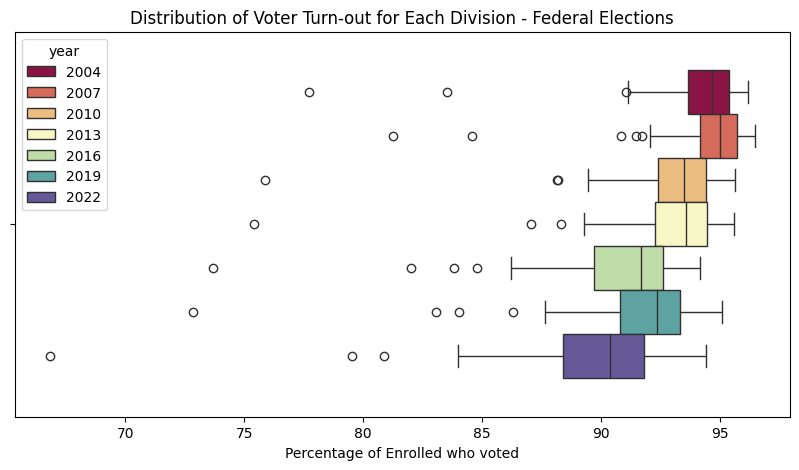

In [9]:
# create box plot of percentage of enrolled voters who voted each year
plt.figure(figsize = (10,5))
sns.boxplot(x = vote_merged["TotalPercentage"], hue = vote_merged["year"], legend = "full", palette = "Spectral")
plt.title("Distribution of Voter Turn-out for Each Division - Federal Elections")
plt.xlabel("Percentage of Enrolled who voted")
plt.show()

In this case the boxplot shows some variation between the earlier years and the later, more recent years. There appears to be an overall downwards trend in voter turn out but further tests will be done to confirm this. However, just from this plot the 2016 and 2022 elections seem to be particularly dramatic decreases with increases in overall distribution as well (box and whiskers are more elongated). 

Looking into this the Australian Electoral Commission's (AEC) report of voter turn out for the 2016 election states that the turn out for the 2016 election was, at that point, the lowest in history since the introduction of compulsory voting <https://www.aec.gov.au/about_aec/research/files/voter-turnout-2016.pdf>. Some of the reasons given were age, indigeneity, and socio-economic status. As for the 2022 election, it was most likely affected by the tail end of COVID-19 restrictions, especially since some states still had some form of restriction at the time of the election.

The boxplot graph also raises the question of which divisions are resposible for the outliers.

In [10]:
# define a highlighting function
def highlight(col):
    return ["background-color: yellow" for val in col]

In [11]:
# which divisions are the outliers with the least voter turnout?
vote_merged.sort_values(by = "TotalPercentage", axis = 0).head(20).\
style.format(precision = 2).apply(highlight, subset = ["DivisionNm", "TotalPercentage"])

,DivisionID,DivisionNm,StateAb,Enrolment,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,TotalPercentage,year
993,306,Lingiari,NT,74008,43928,915,254,2142,2220,49459,66.83,2022
841,306,Lingiari,NT,70023,46075,1015,282,2149,1488,51009,72.85,2019
689,306,Lingiari,NT,63131,42399,748,229,1640,1509,46525,73.70,2016
539,306,Lingiari,NT,65916,45039,1018,231,1861,1566,49715,75.42,2013
389,306,Lingiari,NT,61168,42257,924,126,1860,1242,46409,75.87,2010
89,306,Lingiari,NT,58205,37562,1225,511,4440,1496,45234,77.71,2004
1037,307,Solomon,NT,71843,49055,1055,140,3255,3631,57136,79.53,2022
945,312,Durack,WA,118406,73988,3752,676,5735,11591,95742,80.86,2022
239,306,Lingiari,NT,60404,38096,1115,139,8247,1487,49084,81.26,2007
643,312,Durack,WA,97294,66720,4295,266,2894,5636,79811,82.03,2016


It seems the lowest voter turn out for every single election was the division of Lingiari which cover almost all of the Northern Territory (only excluding a small region around Darwin - division of Solomon). The other common outliers are Solomon, the only other division in the Northern Territory, and Durack/Kalgoorlie (division changed name after 2007) which covers most of rural Western Australia. There does appear to be a commonality among these divisions with poor voter turn out being rural areas with a higher than average level of indigenous voters which matches the finding of the AEC. 

To test whether there is a statistical difference in voter turn out between elections requires analysis of variance (ANOVA) testing.

In [12]:
vote_model = ols(formula = "TotalPercentage ~ C(year)", data = vote_merged).fit()
sm.stats.anova_lm(vote_model, typ = 2)

,sum_sq,df,F,PR(>F)
C(year),2895.674713,6.0,87.129917,1.376812e-88
Residual,5788.253098,1045.0,NaN,NaN


The ANOVA test shows that it is highly likely that the voter turn out between elections is significantly different (incredibly small p value - 1.37*10^-88). However, this only shows that at least one of the election years is significantly different to the others. Tukey's Honestly Significantly Different (HSD) pairwise test can show differences between the individual elections. The significance level will be set to 5% which means that if there's a 5% chance or less for election one's voter turn out to be as different as it is from election two then that difference is considered statistically significant since the probability of getting that much difference randomly is as low as 5%.

In [13]:
vote_tukey = pairwise_tukeyhsd(endog = vote_merged["TotalPercentage"],
                               groups = vote_merged["year"], 
                               alpha = 0.05)
vote_tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
2004,2007,0.4371,0.677,-0.3657,1.2399,False
2004,2010,-1.1057,0.001,-1.9085,-0.3029,True
2004,2013,-1.0847,0.0014,-1.8875,-0.2819,True
2004,2016,-3.3295,0.0,-4.1323,-2.5267,True
2004,2019,-2.4493,0.0,-3.2508,-1.6478,True
2004,2022,-4.5011,0.0,-5.3026,-3.6997,True
2007,2010,-1.5427,0.0,-2.3455,-0.7399,True
2007,2013,-1.5217,0.0,-2.3245,-0.7189,True
2007,2016,-3.7665,0.0,-4.5693,-2.9637,True
2007,2019,-2.8864,0.0,-3.6878,-2.0849,True


The test shows that the differences between the 2004 and 2007 elections aren't statistically significant. The same is true for the 2010 and 2013 elections. But there is a statistically significant difference between all other elections (including from 2007 to 2010). Therefore, there has been a statsically significant decline in voter turn out since the 2004 election.

#### **Vote Type Insights**

-------------------------------------

The data is sufficient to investigate trends in different vote types over the elections covered in this study. A general overview for each election is a good place to start.

In [14]:
# prep data for graphing
vote_merge_graph = vote_merge_year_percent[vote_types].stack(future_stack = True).\
reset_index().rename(columns = {"level_1":"vote_type", 0:"percent"}) 

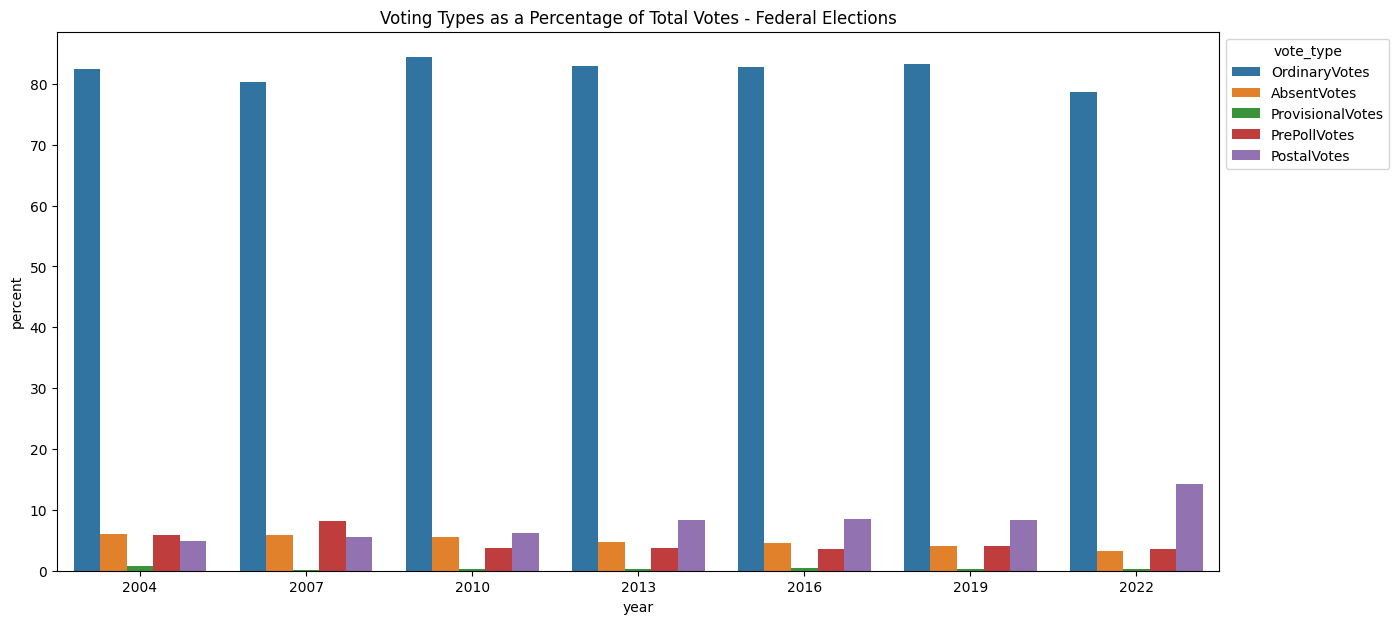

In [15]:
# plot vote type percentages for each election
plt.figure(figsize = (15, 7))
vote_bar = sns.barplot(data = vote_merge_graph, x = "year", y = "percent", hue = "vote_type")
sns.move_legend(vote_bar, "upper left", bbox_to_anchor=(1,1))
plt.title("Voting Types as a Percentage of Total Votes - Federal Elections")
plt.show()

This graph shows the vote type distributions of each election - ordinary votes being by far the most common as would be expected. The most prominent feature of this graph is the increase in postal voting over each election which is likely the cause for the other vote types declining slighly over the same period. The 2022 election in particular had almost twice as many postal votes than previous elections. This may be due to COVID-19 restrictions resulting in an increased number of people wanting to avoid a polling station. 

Looking into which districts had the highest percentages of postal votes for the 2022 election may shed more light.

In [16]:
# which divisions do the most postal voting
vote_merged_percent[vote_merged_percent["year"] == 2022].sort_values(by = "PostalVotes", ascending = False).head(20).\
style.format(precision = 2).apply(highlight, subset = ["StateAb", "PostalVotes"])

,DivisionID,DivisionNm,StateAb,Enrolment,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,TotalPercentage,year
1015,173,Moreton,QLD,107115,67.97,3.76,0.44,4.95,22.88,95181,88.86,2022
914,310,Bonner,QLD,109132,72.35,3.41,0.23,2.39,21.62,98841,90.57,2022
942,252,Dickson,QLD,112786,72.03,3.33,0.21,2.98,21.45,103025,91.35,2022
930,205,Chisholm,VIC,109851,72.10,3.14,0.27,3.39,21.11,101281,92.20,2022
1003,170,Maranoa,QLD,109005,72.96,2.67,0.24,3.24,20.89,96349,88.39,2022
969,164,Groom,QLD,110878,74.84,2.05,0.20,2.18,20.74,100762,90.88,2022
999,322,Macnamara,VIC,110603,68.64,4.95,0.37,5.39,20.66,96333,87.10,2022
1029,176,Rankin,QLD,108054,73.24,3.17,0.39,2.60,20.59,91375,84.56,2022
1034,177,Ryan,QLD,111322,71.40,3.84,0.28,3.94,20.55,102456,92.04,2022
920,156,Brisbane,QLD,125208,67.50,5.00,0.36,6.60,20.53,111110,88.74,2022


All of the top 20 postal voting divisions were in the states of Queensland and Victoria. This could align with COVID-19 restrictions since these two states had arguably the strictest and/or longest lasting restrictions.

Investigating the five divisions with the highest and the lowest percentages of each vote type could provide similar insights if there are connections between divisions.

In [17]:
# create functions to get the division names of the top 5 and bottom 5 for each vote type percentage for each year
def top_five(df, var_list):
    '''
    Creates a dataframe of the 5 divisions with the highest percentage of each vote type for each election
    df = dataframe containing the percentage data of vote types for each division
    var_list = list of vote types - must be within df
    '''
    new_df = df.copy()
    top_df = pd.DataFrame(index = range(0,5))
    for var in var_list:
        for year in new_df["year"].unique().tolist():
            top_df[var + str(year)] = new_df[new_df["year"] == year].sort_values(by = var, ascending = False)["DivisionNm"].tolist()[0:5]
    return top_df.T.rename(columns = {0: "first", 1: "second", 2: "third", 3: "fourth", 4: "fifth"})

def bottom_five(df, var_list):
    '''
    Creates a dataframe of the 5 divisions with the lowest percentage of each vote type for each election
    df = dataframe containing the percentage data of vote types for each division
    var_list = list of vote types - must be within df
    '''
    new_df = df.copy()
    top_df = pd.DataFrame(index = range(0,5))
    for var in var_list:
        for year in new_df["year"].unique().tolist():
            top_df[var + str(year)] = new_df[new_df["year"] == year].sort_values(by = var, ascending = True)["DivisionNm"].tolist()[0:5]
    return top_df.T.rename(columns = {0: "first", 1: "second", 2: "third", 3: "fourth", 4: "fifth"})

In [18]:
# create a dataframe with the top 5 divisions for each vote type for each election
vote_types_full = vote_types + ["TotalPercentage"]
vote_top_five = top_five(vote_merged_percent, vote_types_full)
vote_top_five

,first,second,third,fourth,fifth
OrdinaryVotes2004,Prospect,Braddon,Fowler,Scullin,Wakefield
OrdinaryVotes2007,Braddon,Wakefield,Blair,Bass,Fowler
OrdinaryVotes2010,Lingiari,Calare,Hunter,Throsby,Canberra
OrdinaryVotes2013,Calare,Lingiari,Riverina,Fraser,Canberra
OrdinaryVotes2016,Lingiari,Calare,Page,Whitlam,Riverina
OrdinaryVotes2019,Calare,Bean,Lingiari,Cowper,Whitlam
OrdinaryVotes2022,Calare,Lingiari,Riverina,Whitlam,New England
AbsentVotes2004,O'Connor,Kalgoorlie,Pearce,Melbourne,Sydney
AbsentVotes2007,Sydney,Melbourne,Pearce,Perth,McEwen
AbsentVotes2010,Pearce,Sydney,Brisbane,Canning,O'Connor


There does appear to be some connections among the districts for most of the vote types.

**Ordinary votes** seem to be dominated mostly by divisions in New South Wales, especially rural districts in more recent elections. Outside of the NSW divisions the other divisions also tend to be rural - like Lingiari (NT), Braddon (TAS), Bass (TAS), and Wakefield (SA).

**Absent votes** seem to be particularly dominated by Western Australian divisions. There are fewer WA divisions that don't feature at least once amongst the top fives than those that do. Of the non-WA divisions included in the top fives they are typically inner city divisions of some of the capitals of the other states. It is not immediately clear why Western Australians in particular tend to vote outside their own electorate.

**Provisional votes** seem to have the least commonality amongst divisions. However, there are some divisions that appear multiple times suggesting that issues from previous elections possibly aren't being rectified before the next election.

**PrePoll votes** have a few very rural divisions amongst the top five but are predominately more urban divisions, particularly in Victoria and Western Australia. The 2004 and 2007 elections seem to be different to the other elections - both elections feature the two ACT divisions of Canberra and Fraser along with the NSW division of Gilmore and the rural VIC division of Indi. All of these divisions never appear again in the top five for the subsequent elections.

**Postal votes** are completely dominated by divisions from QLD and VIC. In particular the rural QLD division of Maranoa and the metropolitan VIC division of Melbourne Ports/Macnamara (name changed after 2016 election) were the top two for every election except 2022. It is unclear why QLD and VIC have such a high rate of postal voting compared to other states.

Finally, **Total Percentage/Voter Turnout** results suggest that some of the rural and regional areas of NSW, VIC, and TAS tend to be the most politically involved divisions. The only featured division that isn't from those three states is the rural division of Mayo in SA. The most prolific divisions were the provincial division of Corangamite in VIC and the rural division of Braddon in TAS featuring in the top five for all but the 2022 election.

Investigating a similar table of the divisions with the lowest percentage should provide similar insights.

In [19]:
# create a dataframe with the bottom five divisions for each vote type for each election
vote_bottom_five = bottom_five(vote_merged_percent, vote_types_full)
vote_bottom_five

,first,second,third,fourth,fifth
OrdinaryVotes2004,Melbourne Ports,Wentworth,Gilmore,Maranoa,Melbourne
OrdinaryVotes2007,Melbourne Ports,Gilmore,Melbourne,Flinders,Higgins
OrdinaryVotes2010,Melbourne Ports,Higgins,Brisbane,Sydney,Wright
OrdinaryVotes2013,Melbourne Ports,Isaacs,Higgins,Melbourne,Chisholm
OrdinaryVotes2016,Melbourne Ports,Higgins,Melbourne,Kooyong,Chisholm
OrdinaryVotes2019,Macnamara,Melbourne,Brisbane,Wright,Gorton
OrdinaryVotes2022,Brisbane,Moreton,Macnamara,Melbourne,Wright
AbsentVotes2004,Solomon,Fraser,Canberra,Lingiari,Farrer
AbsentVotes2007,Fraser,Canberra,Solomon,Farrer,Lingiari
AbsentVotes2010,Canberra,Fraser,Solomon,Farrer,Lingiari


The divisions with the lowest **Ordinary votes** contain a lot of the names that featured among the top of the Postal and PrePoll voting (eg Melbourne Ports/Macnamara). There are almost no rural divisions featured which reinforces the previous findings that the rural divisions are more prevalent ordinary voters. The VIC divisions in particular feature heavily in the bottom five for ordinary votes. It's unclear why Victorians tend to seek alternatives to voting on election day.

The **Absent votes** feature a lot of repeating names, the most prevalent being the two ACT divisions of Canberra and Fraser along with the rural NSW division of Farrer. Overall it's the rural divisions that dominate the absent votes which does make some sense since rural areas typically cover a larger area resulting in a larger average distance to a polling booth outside of the division for voters.

There is no obvious trend for divisions with the lowest **Provisional votes**.

The divisions with the lowest **PrePoll votes** are dominated by SA and NSW until the 2019 and 2022 elections where the lowest prepoll votes were dominated by the TAS divisions of Lyons, Braddon, and Bass.

Lowest **Postal votes** are predominately rural areas of NSW and NT. The divisions of Lingiari (NT) and Calare (NSW) have held the lowest and second lowest spots since the 2010 election. Again, this reinforces the notion that rural divisions lean towards ordinary voting but that even rural voters in QLD and VIC have higher tendencies towards postal voting since there isn't a single division from either state featured here in the bottom five for any election.

The division with lowest **Total Percentage/Turn Out** has been discussed previously but this provides a different format showing it by each election. Dominated by rural indigenous divisions like Lingiari and Durack as well as a few inner city Sydney and Melbourne divisions (possibly due to the age factor that the AEC raised as a reason for poor voter turn out).

#### **Conclusion**

---------------------------------

In conclusion, the data has provided numerous insights into voting patterns over the last several federal elections. There does seem to be a statistically significant downwards trend in voter turn out that even the AEC recognizes. The reasons for this vary, issues causing decreased voter turn out in rural areas likely aren't the same as the issues in the metropolitan areas - although it's certainly possible there's a growing feeling of disenfranchisement in both areas but proving that is outside the scope of this study.

There is evidence in the data that divisions in different states tend to have different preferences when it comes to vote type. The strongest case for this seems to be the domination of postal voting by QLD and VIC divisions. There also appears to be some difference between rural and metropolitan divisions with the former leaning towards ordinary voting and the latter leaning towards early voting methods. 

It appears clear that individual divisions have their own quirks and tendencies towards voting since, if it were random and divisions were largely the same, there would be a lot more variation and many more divisions featured among the top five and bottom five for the different voting types. For example, the division of Melbourne Ports features repeatedly in the top five for postal voting. This is a qurik of this division, voters in this specific division have a higher tendency to postal vote than voters elsewhere. It isn't random as it occurs over sereral elections spanning more than a decade, the trend only being broken in 2022 and that was likely due to the extenuating circumstances from COVID-19. 

Individual division matters and is, to a degree, predictable.